# Feature decomposition

Breaking down a complex feature or set of features into simpler, more easily interpretable components, to better understand the underlying structure of data, to reduce the dimensionality of feature space, or to create new feature that are more information for predictive modeling.

**Why Do We Need Feature Decomposition?**
- Less training time, less computational resources, increases the overall performance of ML algorithms
- Avoids the problem of overfitting, help of bias-variance tradeoff, removes noise in the data
- The initial complex problem may be conceptually simplified according to decomposition approaches
- Data visualization
- Takes care of multicollinearity
- Useful for factor analysis, 
- Image compression
- Transform non-linear data into a linearly-separable form


**Method for feature decomposition**
- Principal component analysis (PCA): PCA, kernel PCA
- Independent component analysis (ICA)
- Non-negative matrix factorization (NMF)
- Singular value decomposition (SVD): SVD, truncated SVD
- Linear Discriminant Analysis (LDA)

<img src = "_images/05fd_dimensionality.png">

In [2]:
# load dataset
import pandas as pd
import sklearn.datasets as data

iris = data.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## SVD - (linear)
**Singular value decomposition** thực hiện phân rã 1 matrix bất kỳ thành tích của 3 matrix đặc biệt

<img src = "_images/05fd_svd.png">

trong đó:
- `r` = `rank(A)` là hạng của matrix `A`
- `U` là matrix trực giao có `m` dòng tương ứng là `m` vector đặc trưng của `m` obs
- `V` là matrix trực giao có `n` dòng tương ứng là `n` vector đặc trưng của `n` features
- `S` là ma trận đường chéo có `r` phần tử khác 0, các giá trị `σ` trên đường chéo >=0 và giảm dần

Thông thường trong `r` giá trị `σ` thì chỉ có `k` giá trị đầu tiên là lớn, còn `r-k` giá trị còn lại sẽ gần bằng 0. Khi dó ta xấp xỉ:
$$A\approx A_k = U_kS_kV_{k}^{T}$$ 

**Usage**
- Giảm chiều dữ liệu và phân tích đặc trưng
- Nén dữ liệu
- Clustering
- Recomandation (phân rã SVD và loại bỏ matrix S)
- PCA


In [6]:
import numpy as np
X_demean = X - np.mean(X, axis=0)
U, S, Vt = np.linalg.svd(X_demean)

# cumsum variance depend on k (k<r)
cum_var_explained = np.cumsum(np.square(S))/np.sum(np.square(S))
cum_var_explained

# plot number singular value and cum_explained
import plotly.express as px

fig = px.line(x=range(1,5), y = cum_var_explained,range_y = [0.9,1.05], range_x = [0,5])
# fig.show(renderer = 'nteract')

<img src = "_images/05fd_svd_ncum_explain.png">

In [5]:
# with 2 singular values, that number goes up to approximately 99.8% with all-singular
df = pd.DataFrame(U[:,:3], columns = ['sigma1' , 'sigma2' ,'sigma3' ])
df['label'] = pd.Series(y).replace({0:'setosa',1:'versicolor',2:'virginica'})
df.head()
fig = px.scatter(df, 'sigma1', 'sigma2',color = 'label',height=600)
# fig.show(renderer = 'nteract')

<img src = "_images/05fd_svd_scatter.png">

### TruncatedSVD
- `TruncatedSVD` is very similar to `PCA`, but differs in that the matrix X does not need to be centered. When the columnwise (per-feature) means of X are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the `TruncatedSVD` transformer accepts `scipy.sparse` matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections. Therefore, TruncatedSVD can work with categorical features, but PCA work only with numeric.

- If the data is already centered, those two classes will do the same.

- **In practice TruncatedSVD is useful on large sparse datasets which cannot be centered without making the memory usage explode, while PCA works well with dense data. Truncated SVD can also be used with dense data.** 

- Factorization for `SVD` is done on the `data matrix` while factorization for `PCA` is done on the `covariance matrix`.**

In [15]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
svd.fit(X)

print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

print(svd.singular_values_)


[0.52875361 0.44845576 0.01757678]
0.9947861525045135
[95.95991387 17.76103366  3.46093093]


### SVD for Recommendations

In [16]:
from scipy.sparse.linalg import svds

def svd_process(train, k):
    """
    return matrix xap xi ma tran ban dau voi top k 
    """
    utilMat = np.array(train) if type(train) != np.array else train
    
    # DE-MEAN process
    # the nan or unavailable entries are masked
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1)) # the per item average from all entries
    utilMat = utilMat - x # Remove x (mean), the above mentioned nan entries will be essentially 0 now
    
    # SVD: U and V are user and item features
    U, s, V=svds(utilMat, k)
    s=np.diag(s) # convert singular vector to Diagonalizable matrix
    
    # estimate the apporoximate matrix
    s_root=sqrtm(s) # then s = s_root.dot(s_root)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x
    # print("svd done")
    return UsV

## PCA - (linear)
Project data points in high-dimensional space down to a small number of principal component vectors in low-dimensional space while preserving maximum variability of data after transformation. Combine multiple nummeric predictor variables into a smaller set of variables, but remain most of variability of the full set of variables, reducing the dimension of the data, also minimize correlation between components.
- The advantage of `PCA` is that it uses all input variables so this method does not miss important variables.
- The disavantages of `PCA` that `PCA` won't work well with data is linearly inseparable, if that was, should use `kernel PCA`

**Eigen value - Eigen vector**

Khi ma trận hiệp phương sai A (thể hiện biến thiên của các biến với nhau) khi chiếu lên chiều mới là u (tức A𝛍) thì kết quả thu được chỉ là tỷ lệ của chiều đó (𝛌𝛍), tức các biến thiên ban đầu có ựu độc lập với nhau theo chiều u và có tỷ lệ độ dài trên chiều u --> thể hiện đầy đủ covariance A.
Khi đó: 𝛌 eigen value, 𝛍 eigen vector của A

**PCA Process**
1. de-mean ma trận dữ liệu, đưa các features có mean = 0: X_demean = x - x_mean
2. Tính covariance matrix của ma trận X_demean
3. Tính eigen value + eigen vector của matrix covariance với norm 2, sắp xếp lại các eigen value giảm dần
4. lựa chọn k vector đi kèm có eigen value lớn nhất để xây hệ mới, k eigen vector tạo thành matrix 𝛍(k) mới
5. Chiếu X_demean lên hệ mới được bộ dữ liệu với hệ toạ độ Z = 𝛍(k)_transpose * X_demean,

Dữ liệu gốc được tính xấp xỉ : x = 𝛍(k) * Z + x_mean.

Lựa chọn k sao cho lượng cumulative variance exceeds a threshold, such as 80%

**So sánh PCA với Linear Discriminant Analysis (LDA)**
- LDA Là phương pháp giảm chiều dữ liệu cho bài toán classification, bổ sung thông tin về label dữ liệu, áp dụng cho cả việc giảm chiều cũng như bài toán phân loại. Khác với PCA là giảm chiều nhưng giữ lại mức độ variance của dữ liệu lớn nhất và ko cần thông tin về label của class (không phải việc giữ lại thông tin nhiều nhất sẽ luôn mang lại kết quả tốt nhất khi phân loại)
- The major difference between LDA and PCA is that LDA finds a linear combination of input features that optimizes class separability while PCA attempts to find a set of uncorrelated components of maximum variance in a dataset.
- PCA is an unsupervised algorithm whereas LDA is a supervised algorithm where it takes class labels into account.

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
pca.fit(X_train)

# eigenvector_subset
pca.components_

pca.explained_variance_

### PCA for image

In [28]:
# load data
data = pd.read_csv('Datasets/mnist.zip', nrows=5000).drop(columns = ['label'])
print(data.min().min(), data.max().max())

0 255


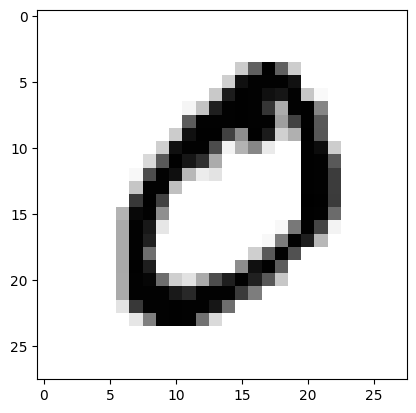

In [27]:
import matplotlib.pyplot as plt

def display_image(ind, data = data, shape = (28,28)):
    image = data.iloc[ind].values.reshape(list(shape))
    return plt.imshow(image, cmap='gray_r')

display_image(1)

Text(0, 0.5, 'Explained variance')

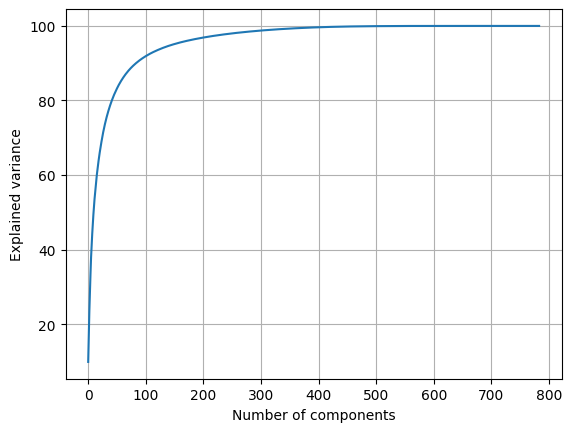

In [31]:
# Choose the right number of dimensions
# load the cum variance for fully dimessions
from sklearn.decomposition import PCA
pca_784 = PCA(n_components=28*28)
pca_784.fit(data)

plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

Text(0.5, 1.0, 'Compressed image with 184 components')

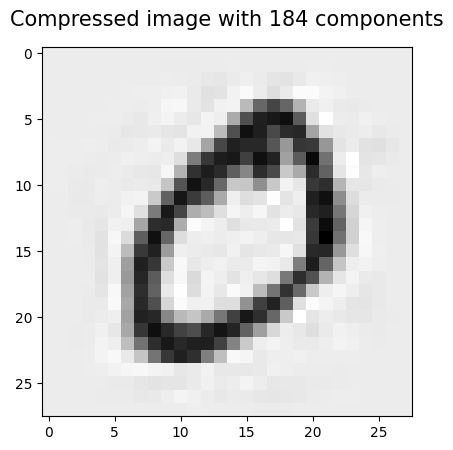

In [32]:
# use 184 components to get about 96% variability in the original data
pca_184 = PCA(n_components=184)
data_pca_184_reduced = pca_184.fit_transform(data)
data_pca_184_recovered = pca_184.inverse_transform(data_pca_184_reduced)

image_pca_184 = data_pca_184_recovered[1,:].reshape([28,28])
plt.imshow(image_pca_184, cmap='gray_r')
plt.title('Compressed image with 184 components', fontsize=15, pad=15)

### Incremental PCA
The PCA object is very useful, but has certain limitations for large datasets. The biggest limitation is that PCA only supports batch processing, which means all of the data to be processed must fit in main memory. The IncrementalPCA object uses a different form of processing and allows for partial computations which almost exactly match the results of PCA while processing the data in a minibatch fashion. IncrementalPCA makes it possible to implement out-of-core Principal Component Analysis either by:

- Using its partial_fit method on chunks of data fetched sequentially from the local hard drive or a network database.
- Calling its fit method on a sparse matrix or a memory mapped file using `numpy.memmap`.

IncrementalPCA only stores estimates of component and noise variances, in order update `explained_variance_ratio_` incrementally. This is why memory usage depends on the number of samples per batch, rather than the number of samples to be processed in the dataset.

As in PCA, IncrementalPCA centers but does not scale the input data for each feature before applying the SVD.

In [17]:
from sklearn.decomposition import IncrementalPCA

## Linear Discriminant Analysis (LDA) - (linear)
- LDA Là phương pháp giảm chiều dữ liệu cho bài toán multi-class classification, bổ sung thông tin về label dữ liệu, áp dụng cho cả việc giảm chiều cũng như bài toán phân loại. Khác với PCA là giảm chiều nhưng giữ lại mức độ variance của dữ liệu lớn nhất và ko cần thông tin về label của class (không phải việc giữ lại thông tin nhiều nhất sẽ luôn mang lại kết quả tốt nhất khi phân loại)
- Trong LDA:
    - Hai classes được gọi là discriminative nếu hai class đó cách xa nhau (between-class variance lớn) và dữ liệu trong mỗi class có xu hướng giống nhau (within-class variance nhỏ). LDA là thuật toán đi tìm một phép chiếu sao cho tỉ lệ giữa between-class variance và within-class variance lớn nhất có thể.
    - Số chiều không gian mới sau khi giảm chiều bằng LDA thì ko  vượt quá C-1, với C là số lượng class của label
    - LDA có giả sử ngầm rằng dữ liệu của các classes đều tuân theo phân phối chuẩn và các ma trận hiệp phương sai của các classes là gần nhau
    - LDA does not need to recenter/scale data like PCA
    - LDA hoạt động rất tốt nếu các classes là linearly separable, tuy nhiên, chất lượng mô hình giảm đi rõ rệt nếu các classes là không linearly separable. Điều này dễ hiểu vì khi đó, chiếu dữ liệu lên phương nào thì cũng bị chồng lần, và việc tách biệt không thể thực hiện được như ở không gian ban đầu.
-     
        
- **Within-class variances (SSwithin)**: Phương sai s2 của từng class khi chiếu lên 1 chiều nhất định, thể hiện mức độ phân tán dữ liệu của class khi chiếu lên chiều đó. Kỳ vọng càng thấp càng tốt.

- **Between-class variance (SSbetween)**: Khoảng cách giữa 2 kỳ vọng của 2 class, thể hiện mức độ cách xa nhau của 2 class: (m1-m2)^2

Text(0, 0.5, 'LD2')

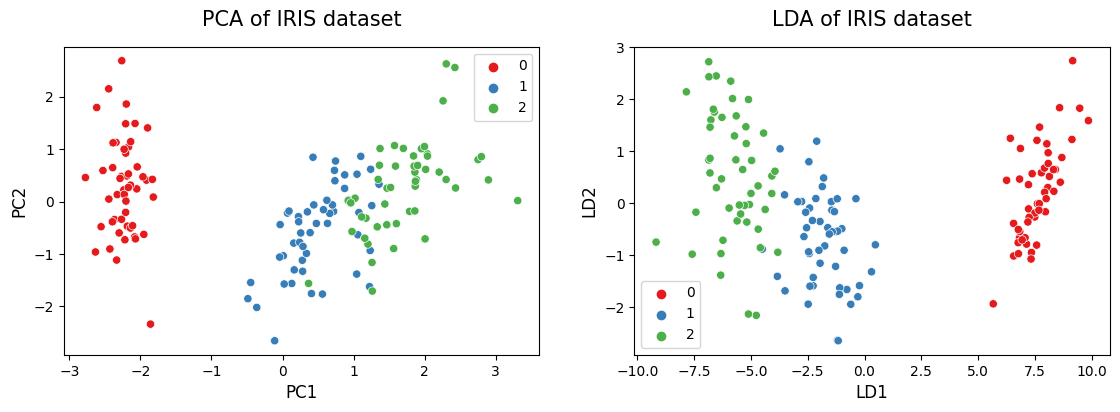

In [36]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = load_iris()
X = iris.data
y = iris.target

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
X_lda = lda.fit_transform(X, y)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5 ,4))
sns.scatterplot(x=X_pca[:,0], y = X_pca[:,1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(x=X_lda[:,0], y = X_lda[:,1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA of IRIS dataset", fontsize=15, pad=15)
ax[1].set_title("LDA of IRIS dataset", fontsize=15, pad=15)
ax[0].set_xlabel("PC1", fontsize=12)
ax[0].set_ylabel("PC2", fontsize=12)
ax[1].set_xlabel("LD1", fontsize=12)
ax[1].set_ylabel("LD2", fontsize=12)

## Factor analysis (FA) - (linear)
Factor Analysis is a useful approach to find `latent variables` which are not directly measured in a single variable but rather inferred from other variables in the dataset **--> FA is a model of the measurement of latent variables**

In [40]:
data = pd.read_csv('Datasets/women_track_records.csv')

X = data.iloc[:, 1:8]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=2, rotation="varimax", method="principal", 
                    is_corr_matrix=False)
fa.fit(X_scaled)

print("Eigenvalues:")
print(fa.get_eigenvalues()[0])
print()
print("Communalities:")
print(fa.get_communalities())
print()
print("Specific Variances:")
print(fa.get_uniquenesses())
print()
print("Factor Loadings:")
print(fa.loadings_)

Eigenvalues:
[5.06759677 0.6020256  0.44429295 0.36590389 0.26931274 0.13929091
 0.11157713]

Communalities:
[0.8632044  0.86854473 0.77623794 0.84827979 0.79619776 0.73826138
 0.77889637]

Specific Variances:
[0.1367956  0.13145527 0.22376206 0.15172021 0.20380224 0.26173862
 0.22110363]

Factor Loadings:
[[0.8399412  0.3971186 ]
 [0.86109019 0.35646657]
 [0.81415209 0.33674071]
 [0.61543129 0.6852183 ]
 [0.22614824 0.86316553]
 [0.48965453 0.7060452 ]
 [0.46668107 0.74906952]]


## Kernel PCA - (non-linear)
- `Kernel PCA` is a non-linear dimensionality reduction technique that uses kernels. 
- It can also be considered as the non-linear form of normal `PCA`. 
- `Kernel PCA` works well with non-linear datasets where normal `PCA` cannot be used efficiently.

**Procedure**:
1. The data is first run through a `kernel function` and temporarily projects them into a new higher-dimensional feature space where the classes become linearly separable.
2. Then the algorithm uses the `normal PCA` to project the data back onto a lower-dimensional space

**Kernel PCA hyperparameters:**
- `n_components`: the number of components we want to keep
- `kernel`: the type of kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’}. The `rbf` kernel which is known as the radial basis function kernel is the most popular one.
- `gamma`: the kernel coefficient, use `GridSearch` to find an optimal value for the `gamma`

<AxesSubplot: >

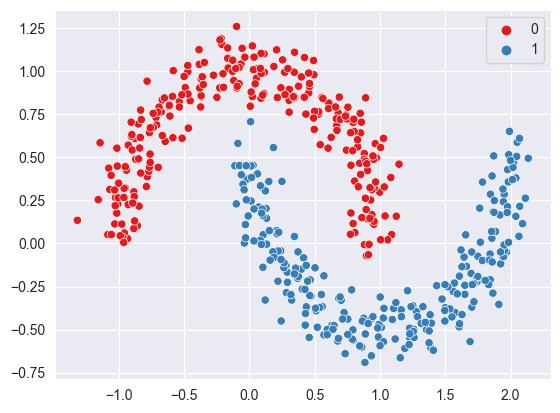

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
sns.set_style('darkgrid')

X, y = make_moons(n_samples = 500, noise = 0.1)
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=y, palette='Set1')

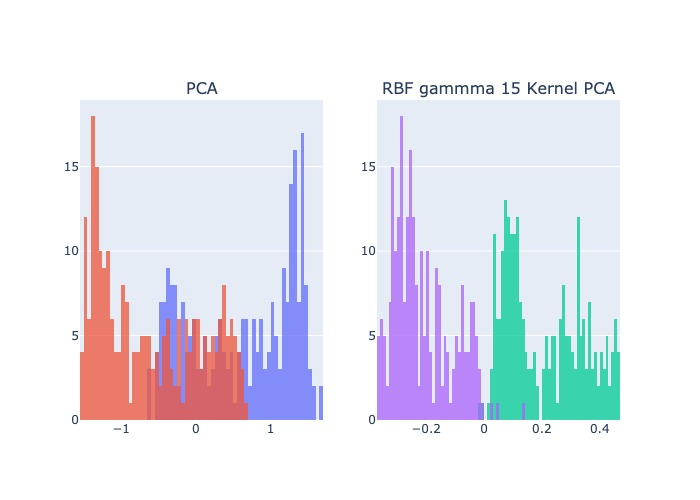

In [89]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, subplot_titles = ['PCA','RBF gammma 15 Kernel PCA'])
fig.add_trace(go.Histogram(x = X_pca[y==0, 0], name = 'y=0', bingroup = 1, nbinsx = 100), row=1, col=1)
fig.add_trace(go.Histogram(x = X_pca[y==1, 0], name = 'y=1', bingroup = 1, nbinsx = 100), row=1, col=1)
fig.add_trace(go.Histogram(x = X_kpca[y==0, 0], name = 'y=0', bingroup = 2, nbinsx = 100), row=1, col=2)
fig.add_trace(go.Histogram(x = X_kpca[y==1, 0], name = 'y=1', bingroup = 2, nbinsx = 100), row=1, col=2)
fig.update_layout(showlegend=False, barmode='overlay', )
fig.update_traces(opacity=0.75)
fig.show(renderer = 'jpeg')

## t-SNE - (non-linear)
- Mostly used for data visualization and used in image processing and NLP. 
- Recommends to use PCA or Truncated SVD before t-SNE if the number of features in the dataset is more than 50.

Text(0.5, 1.0, 't-SNE of IRIS dataset')

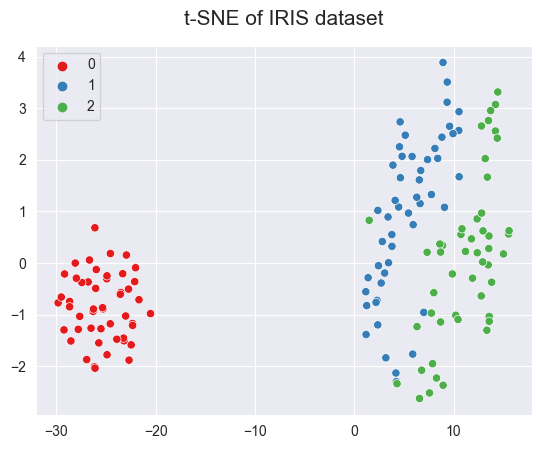

In [91]:

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
sns.set_style('darkgrid')

iris = load_iris()
X = iris.data
y = iris.target

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X_scaled)

sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], hue=y, palette='Set1')
plt.title("t-SNE of IRIS dataset", fontsize=15, pad=15)

## Multidimensional Scaling (MDS) - (non-linear)
- `MDS` tries to preserve the distances between instances while reducing the dimensionality of non-linear data. 
- There are two types of MDS algorithms: Metric and Non-metric. The MDS() class in the Scikit-learn implements both by setting the `metric` hyperparameter to `True` (for Metric type) or `False` (for Non-metric type).

Text(0.5, 1.0, 'MDS of IRIS dataset')

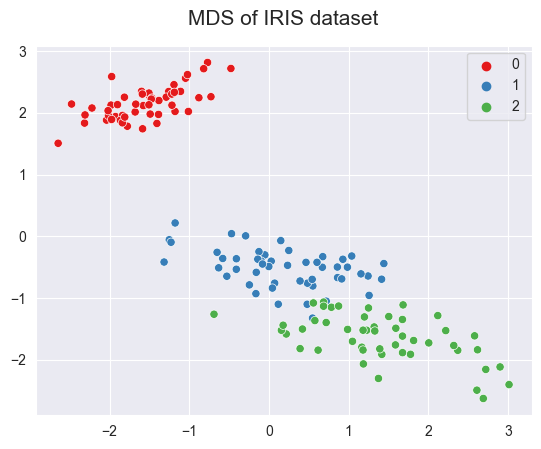

In [94]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric=True, random_state=2, normalized_stress= 'auto')
X_mds = mds.fit_transform(X)

sns.scatterplot(x = X_mds[:,0], y = X_mds[:,1], hue=y, palette='Set1')
plt.title("MDS of IRIS dataset", fontsize=15, pad=15)

## Isomap - (non-linear)
- This method performs non-linear dimensionality reduction through Isometric mapping. It is an extension of MDS or Kernel PCA.
- It connects each instance by calculating the `curved` or `geodesic` distance to its nearest neighbors and reduces dimensionality. The number of neighbors to consider for each point can be specified through the `n_neighbors` hyperparameter

/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning:

The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/Users/khongdat/miniforge3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



Text(0.5, 1.0, 'Isomap of IRIS dataset')

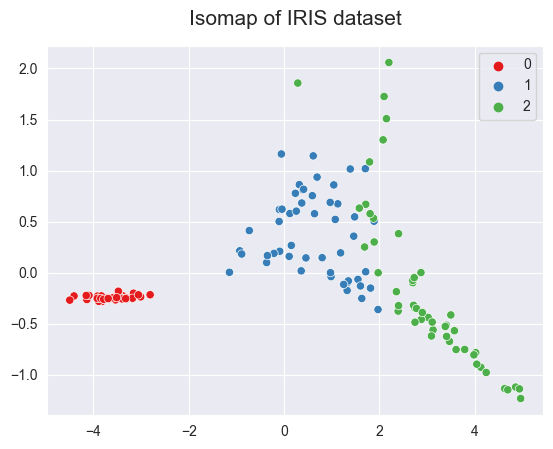

In [100]:
from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors=5, n_components=2, eigen_solver='auto')
X_isomap = isomap.fit_transform(X)

sns.scatterplot(x  = X_isomap[:,0], y = X_isomap[:,1], hue=y, palette='Set1')
plt.title("Isomap of IRIS dataset", fontsize=15, pad=15)

## Locally Linear Embedding - (non-linear)

https://thetalog.com/machine-learning/locally-linear-embedding/

**type data LLE handle**

![image.png](https://plotly.com/~SolClover/146.png)

**Workflow**
1. Use a KNN approach to find the k nearest neighbors of every data point. Here, “k” is an arbitrary number of neighbors that you can specify within model hyperparameters.

2. Construct a weight matrix where every point has its weights determined by minimizing the error of the cost function shown below. Note that every point is a linear combination of its neighbors, which means that weights for non-neighbors are 0.

3. Find the positions of all the points in the new lower-dimensional embedding by minimizing the cost function shown below. Note, here we use weights (W) from step two and solve for Y. The actual solving is performed using Partial Eigenvalue Decomposition.

**LLE variants**
- Modified LLE (MLLE) — use multiple weight vectors in each neighborhood. (**MLLE to perform well in most scenarios**)
- Hessian LLE (HLLE) — solving the regularization problem of LLE, It revolves around a hessian-based quadratic form at each neighborhood used to recover the locally linear structure.


**Difference between LLE and Isomap**
- Similar to LLE, Isomap also uses KNN to find the nearest neighbors in the first step. 
- However, the second step constructs neighborhood graphs instead of describing each point as a linear combination of its neighbors. Then it uses these graphs to compute the shortest path between every pair of points.
- Isomap uses those pairwise distances between all points to construct a lower-dimensional embedding.
- However, because LLE focuses on preserving only the local structures, it may introduce some unexpected distortions on the global scale.

**--> `LLE` is a more efficient algorithm than `Isomap`**

With LLE being designed to focus on local structures, it can perform computations faster than other similar algorithms such as Isomap. However, choosing which algorithm you should use will depend on the data and the task you need to perform.

In [101]:
# Data manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Visualization
import plotly.express as px # for data visualization

# Skleran
from sklearn.datasets import make_swiss_roll # for creating swiss roll
from sklearn.manifold import LocallyLinearEmbedding as LLE # for LLE dimensionality reduction
from sklearn.manifold import Isomap # for Isomap dimensionality reduction

In [102]:
# create data
# Create a swiss roll
X, y = make_swiss_roll(n_samples=2000, noise=0.05)

# Make it thinner
X[:, 1] *= .5

# Create a flat addon to the top of the swiss roll
X_x=np.zeros((300,1))
X_y=np.random.uniform(low=0, high=10, size=(300,1))
X_z=np.random.uniform(low=14, high=25, size=(300,1))
X2=np.concatenate((X_x, X_y, X_z), axis=1)
y2=X_z.reshape(300)

# Concatenate swiss roll and flat rectangle arrays
X_two=np.concatenate((X, X2))
y_two=np.concatenate((y, y2))

In [103]:
# Create a 3D scatter plot
def Plot3D(X, y, plot_name):
    fig = px.scatter_3d(None, 
                        x=X[:,0], y=X[:,1], z=X[:,2],
                        color=y,
                        height=800, width=800
                       )
    # Update chart looks
    fig.update_layout(title_text=plot_name,
                      showlegend=False,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=1.75, z=1)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, 
                                  line=dict(color='black', width=0.1)))
    fig.update(layout_coloraxis_showscale=False)
    return fig
    
    
#----------------------------------------------      
# Create a 2D scatter plot
def Plot2D(X, y, plot_name):
    # Create a scatter plot
    fig = px.scatter(None, x=X[:,0], y=X[:,1], 
                     labels={
                         "x": "Dimension 1",
                         "y": "Dimension 2",
                     },
                     opacity=1, color=y)

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    # Set figure title
    fig.update_layout(title_text=plot_name)

    # Update marker size
    fig.update_traces(marker=dict(size=5,
                                 line=dict(color='black', width=0.3)))
    return fig

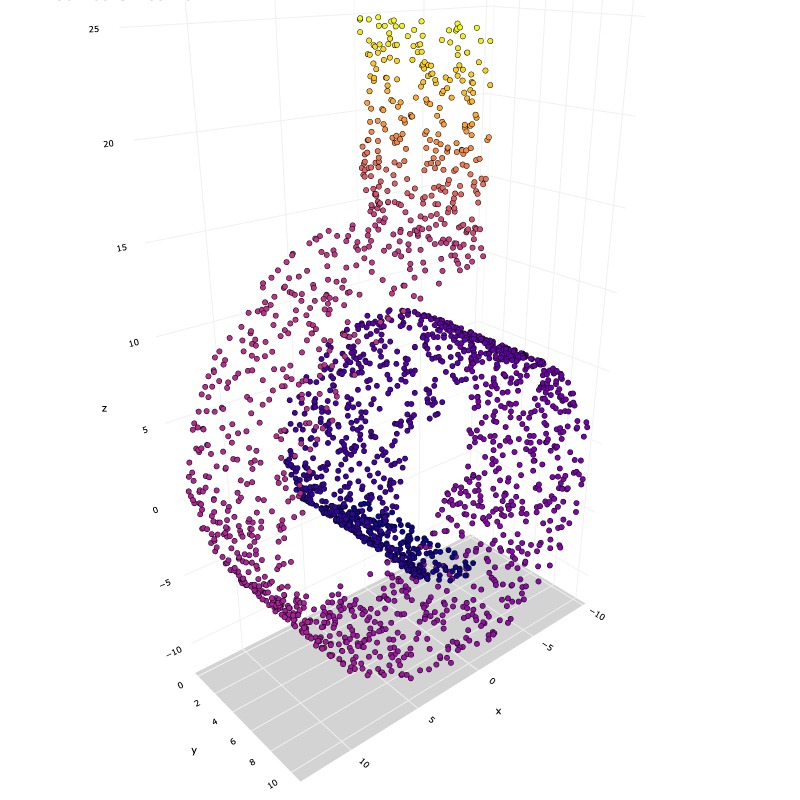

In [114]:
fig = Plot3D(X_two, y_two, 'Modified Swiss Roll')
fig.show(renderer = 'jpeg')

In [109]:
# Function for performing LLE and MLLE
def run_lle(num_neighbors, dims, mthd, data):
    # Specify LLE parameters
    embed_lle = LLE(n_neighbors=num_neighbors, # default=5, number of neighbors to consider for each point.
                    n_components=dims, # default=2, number of dimensions of the new space 
                    reg=0.001, # default=1e-3, regularization constant, multiplies the trace of the local covariance matrix of the distances.
                    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’, auto : algorithm will attempt to choose the best method for input data
                    #tol=1e-06, # default=1e-6, Tolerance for ‘arpack’ method. Not used if eigen_solver==’dense’.
                    #max_iter=100, # default=100, maximum number of iterations for the arpack solver. Not used if eigen_solver==’dense’.
                    method=mthd, # {‘standard’, ‘hessian’, ‘modified’, ‘ltsa’}, default=’standard’
                    #hessian_tol=0.0001, # default=1e-4, Tolerance for Hessian eigenmapping method. Only used if method == 'hessian'
                    modified_tol=1e-12, # default=1e-12, Tolerance for modified LLE method. Only used if method == 'modified'
                    neighbors_algorithm='auto', # {‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’, algorithm to use for nearest neighbors search, passed to neighbors.NearestNeighbors instance
                    random_state=42, # default=None, Determines the random number generator when eigen_solver == ‘arpack’. Pass an int for reproducible results across multiple function calls.
                    n_jobs=-1 # default=None, The number of parallel jobs to run. -1 means using all processors.
                   )
    # Fit and transofrm the data
    result = embed_lle.fit_transform(data)
    
    # Return results
    return result

#----------------------------------------------   
# Function for performing Isomap
def run_isomap(num_neighbors, dims, data):
    # Specify Isomap parameters
    embed_isomap = Isomap(n_neighbors=num_neighbors, n_components=dims, n_jobs=-1)
    
    # Fit and transofrm the data
    result = embed_isomap.fit_transform(data)
    
    # Return results
    return result

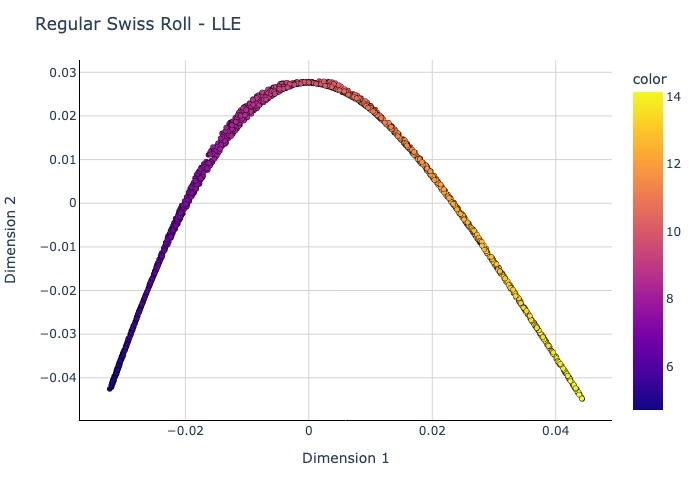

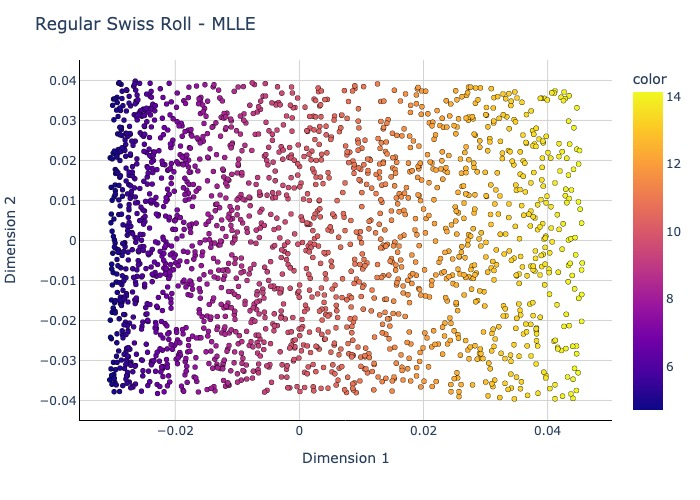

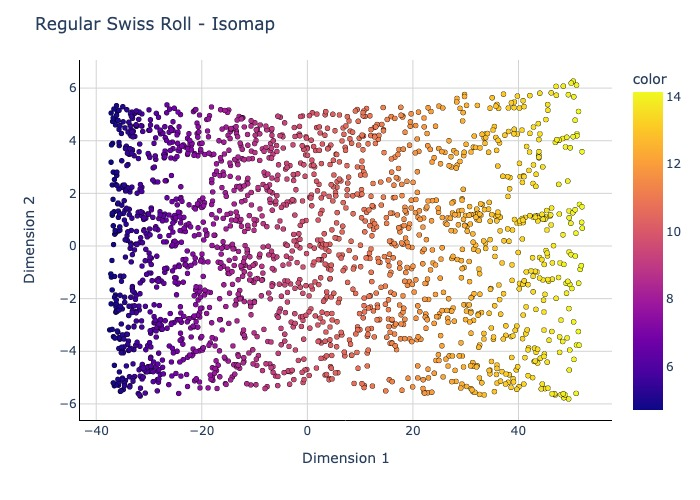

In [116]:
######### Regular swiss roll #########

# Standard LLE on a regular swiss roll
std_lle_res=run_lle(num_neighbors=30, dims=2, mthd='standard', data=X)

# Modified LLE on a regular swiss roll
mlle_res=run_lle(num_neighbors=30, dims=2, mthd='modified', data=X)

# Isomap on a regular swiss roll
isomap_res=run_isomap(num_neighbors=30, dims=2, data=X)


Plot2D(std_lle_res, y, 'Regular Swiss Roll - LLE').show(renderer = 'jpeg')
Plot2D(mlle_res, y, 'Regular Swiss Roll - MLLE').show(renderer = 'jpeg')
Plot2D(isomap_res, y, 'Regular Swiss Roll - Isomap').show(renderer = 'jpeg')

MLLE seems to have the least distorted 2D embedding.

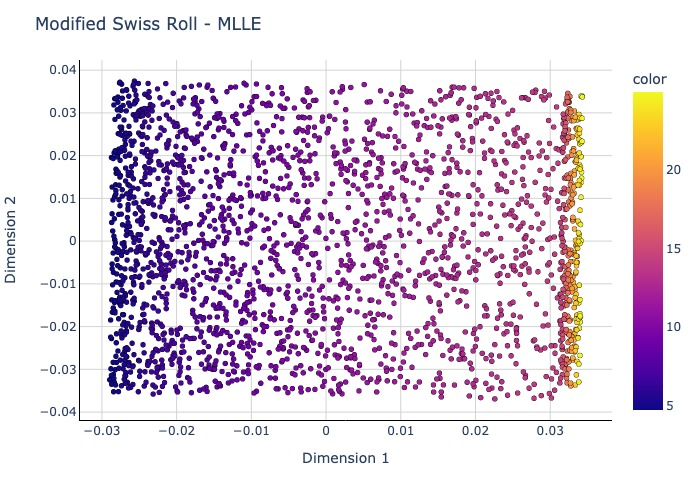

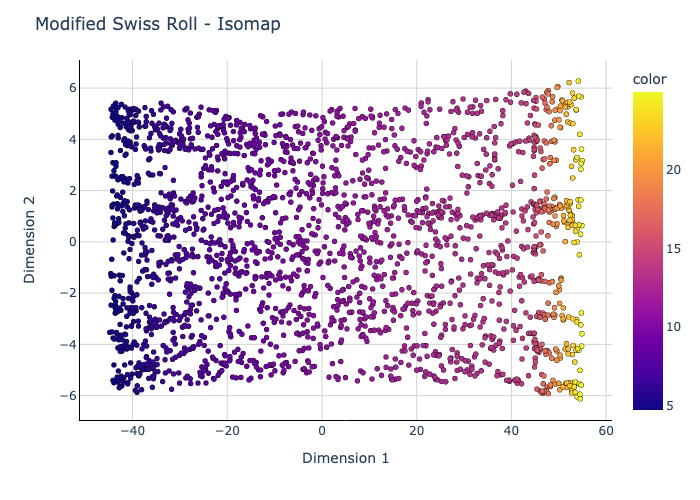

In [115]:
######### Modified swiss roll #########

# Modified LLE on a modified swiss roll
mod_mlle_res=run_lle(num_neighbors=30, dims=2, mthd='modified', data=X_two)

# Isomap on a modified swiss roll
mod_isomap_res=run_isomap(num_neighbors=30, dims=2, data=X_two)

Plot2D(mod_mlle_res, y_two, 'Modified Swiss Roll - MLLE').show(renderer = 'jpeg')
Plot2D(mod_isomap_res, y_two, 'Modified Swiss Roll - Isomap').show(renderer = 'jpeg')

## Autoencoder
- Autoencoder is an unsupervised artificial neural network that compresses the data to lower dimension and then reconstructs the input back. It's based on Encoder-Decoder architecture, where encoder encodes the high-dimensional data to lower-dimension and decoder takes the lower-dimensional data and tries to reconstruct the original high-dimensional data.
![vae.png](https://theaisummer.com/static/25f603171034d2fc8f6a518b8537f85a/ee604/vae.png)
- The mapping of higher to lower dimensions can be linear or non-linear depending on the choice of the activation function.
https://en.wikipedia.org/wiki/Activation_function

**Comparision : PCA versus AutoEncoders**
| index | key | PCA | AutoEncoders |
| --- | --- | --- | --- |
| 1 | Architecture | Eigendecomposition or Singular Value Decomposition (SVD) of the covariance matrix | neural network-based architecture that is more complex |
| 2 | Linear vs non-linear | Linear-data only | linear or non-linear |
| 3 | Training time | fast calculate | trains through Gradient descent and is slower |
| 4 | Size of the input dataset | small datasets | larger datasets |
| 5 | Tunning | hyperparameter is ‘k’ i.e. number of orthogonal dimensions to project data | the architecture of the neural network |
| 6 | Interpretability | Linear combination feature, similar AE with 1-layer | Blackbox |
| 7 | Usage, works well with: | **numerical data:** dimensionality reduction | **image data:** dimensionality reduction, image denoising, image colonization, super-resolution, image compression, feature extraction, image generation, watermark removal,...  |

**Different types of Autoencoders**
https://iq.opengenus.org/types-of-autoencoder/
- Denoising Autoencoder
- Sparse Autoencoder
- Deep Autoencoder
- Contractive Autoencoder
- Undercomplete Autoencoder
- Convolutional Autoencoder
- Variational Autoencoder

In [1]:
# Load the Wine dataset
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target

print("Wine dataset size:", X.shape)

Wine dataset size: (178, 13)


PCA reduced wine dataset size: (178, 8)


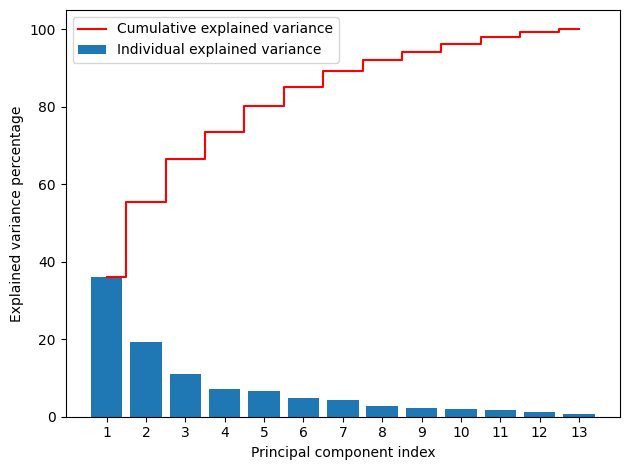

In [2]:
# PCA
# Feature scaling
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the best number of components
# by running PCA with all components
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Plot cumulative explained variances
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 14), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 14), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, 14)))
plt.legend(loc='best')
plt.tight_layout()


# Run PCA again with selected (8) components
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
print("PCA reduced wine dataset size:", X_pca.shape)

In [5]:
# autoencoder

import numpy as np
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

# Build the autoencoder
input_dim = X.shape[1]
latent_vec_dim = 8

input_layer = Input(shape=(input_dim,))

# Define encoder
x = Dense(8, activation='relu')(input_layer)
x = Dense(4, activation='relu')(x)
encoder = Dense(latent_vec_dim, activation="tanh")(x)

# Define decoder
x = Dense(4, activation='relu')(encoder)
x = Dense(8, activation='relu')(x)
decoder = Dense(input_dim, activation="sigmoid")(x)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model with optimizer and loss function
autoencoder.compile(optimizer="adam", loss="mse")

# Train the model with 100 epochs
autoencoder.fit(X_scaled, X_scaled, epochs=100, verbose=0,
                batch_size=16, shuffle=True)

# Use the encoder part to obtain the lower dimensional,
# encoded representation of the data
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_encoded = encoder_model.predict(X_scaled)

# Print the shape of the encoded data
print("Autoencoder reduced wine dataset size:", X_encoded.shape)

Metal device set to: Apple M1 Pro


2023-03-16 15:32:11.529863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 15:32:11.530064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-16 15:32:12.161468: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-16 15:32:12.361437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 5ms/step
Autoencoder reduced wine dataset size: (178, 8)


2023-03-16 15:32:21.832450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0, 0.5, 'Dimension 2')

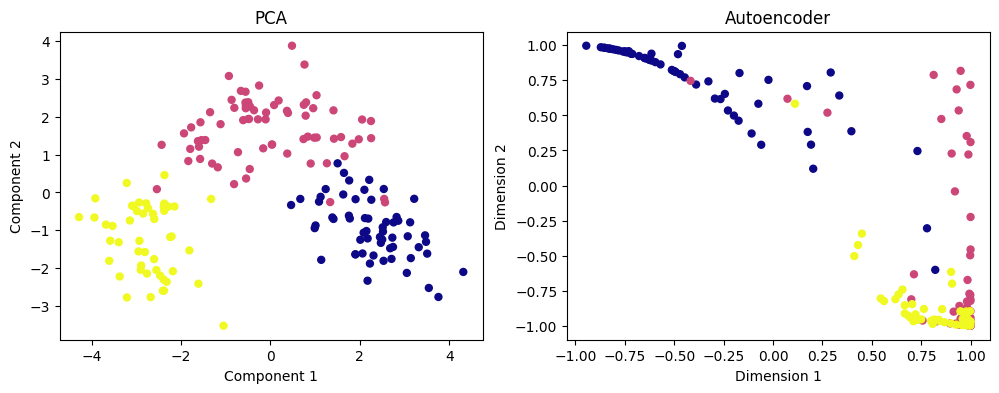

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot PCA output
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=25, cmap='plasma')
ax1.set_title('PCA')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')

# Plot autoencoder output
ax2.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y, s=25, cmap='plasma')
ax2.set_title('Autoencoder')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')